<a href="https://colab.research.google.com/github/Jinzhao-Yu/BioStat615/blob/main/BIOSTAT615_Lecture_5_Fall_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BIOSTAT615 Lecture 5 - R

In [1]:
## load libraries needed
library(Matrix)
library(ggplot2)

## 1. Using `Matrix` R package


In [2]:
## Create a 2x5 dense matrix 
A = matrix(c(0,-1,-1,-1,1,0,0,0,0,-2),2,5)
## A = matrix(c(-1,0,0,0,-1,0,0,-1,0,0,0,0,0,1,0,0,0,0,0,0,-2),3,7) ## Another 3x7 example with more zeros
print(A)

     [,1] [,2] [,3] [,4] [,5]
[1,]    0   -1    1    0    0
[2,]   -1   -1    0    0   -2


In [8]:
A = matrix(c(-1,0,0,0,-1,0,0,-1,0,0,0,0,0,1,0,0,0,0,0,0,-2),3,7) ## Another 3x7 example with more zeros
print(A)

     [,1] [,2] [,3] [,4] [,5] [,6] [,7]
[1,]   -1    0    0    0    0    0    0
[2,]    0   -1   -1    0    1    0    0
[3,]    0    0    0    0    0    0   -2


In [9]:
## Convert the matrix into various sparse representations
A_dgr = as(A,"RsparseMatrix") # Convert to CSR matrix
A_dgc = as(A,"CsparseMatrix") # Convert to CSC matrix
A_dgt = as(A,"TsparseMatrix") # Convert to sparse triplets

In [10]:
## print the structure of CSR matrix
print(A_dgr@p) # 0-based row pointers
print(A_dgr@j) # 0-based column indices
print(A_dgr@x) # Actual non-zero values

[1] 0 1 4 5
[1] 0 1 2 4 6
[1] -1 -1 -1  1 -2


In [11]:
# print the structure of CSC matrix
print(A_dgc@p) # 0-based column pointers
print(A_dgc@i) # 0-based row indices
print(A_dgc@x) # Actual non-zero values

[1] 0 1 2 3 3 4 4 5
[1] 0 1 1 1 2
[1] -1 -1 -1  1 -2


In [12]:
# print the structure of triplet-sparse-matrix
print(A_dgt@i) # 0-based row indices
print(A_dgt@j) # 0-based column indices
print(A_dgt@x) # Actual non-zero values

[1] 0 1 1 1 2
[1] 0 1 2 4 6
[1] -1 -1 -1  1 -2


## 2. Memory cost for sparse matices


Let's create a sparse matrix with a known sparsity.

If we create a $10,000 \times 10,000$ matrix with $5,000$ non-zero elements, what is the sparsity of the matrix?

In [13]:
## create a large sparse matrix
dims = c(10000,10000) ## total dimension : 10k by 10k
nums = 5000 ## number of positive elements = 5k 
## nums = 50000 ## number of positive elements = 50k 

In [14]:
i = sample(1:dims[1],nums,replace=TRUE) # row index
j = sample(1:dims[2],nums,replace=TRUE) # column index
x = sample(c(-2,-1,1,2),nums,replace=TRUE)      # values
M_dgc = sparseMatrix(i=i,j=j,x=x,dims=dims) 
print(object.size(M_dgc),unit="Kb")

99.1 Kb


In [15]:
#convert CSC to CSR
M_dgr = as(M_dgc,"RsparseMatrix")
print(object.size(M_dgr),unit="Kb")

99.1 Kb


In [16]:
#convert CSC to COO
M_dgt = as(M_dgc,"TsparseMatrix")
print(object.size(M_dgt),unit="Kb")

79.6 Kb


In [17]:
#convert CSC to dense
M_dense = as.matrix(M_dgc)
print(object.size(M_dense),unit="Mb")

762.9 Mb


## 3. Compute cost for sparse matrices

In [18]:
## Matrix Vector Multiplications
## Calculate rowSums 
ones = rep(1,length=dims[2])
system.time(a_dgc <- M_dgc%*%ones)
system.time(a_dgr <- M_dgr%*%ones)
system.time(a_dgt <- M_dgt%*%ones)
system.time(a_dense <- M_dense%*%ones)

   user  system elapsed 
  0.001   0.000   0.001 

   user  system elapsed 
  0.004   0.000   0.005 

   user  system elapsed 
  0.003   0.000   0.003 

   user  system elapsed 
  0.161   0.000   0.161 

In [19]:
## Matrix-Matrix multiplication
## Calculate t(M) %*% M
system.time(X_dgc <- crossprod(M_dgc))
system.time(X_dgr <- crossprod(M_dgr))
system.time(X_dgt <- crossprod(M_dgt))
system.time(X_dense <- crossprod(M_dense))

   user  system elapsed 
  0.002   0.001   0.003 

   user  system elapsed 
  0.006   0.000   0.007 

   user  system elapsed 
  0.003   0.000   0.003 

   user  system elapsed 
 30.894   0.624  31.602 

In [20]:
## Matrix-Matrix multiplication
## Calculate cholesky decomposition 
## (after adding a diagnoal offset to make it positive definite)
system.time(chol_dgc <- chol(X_dgc+.sparseDiagonal(dims[2])))
system.time(chol_dgr <- chol(X_dgr+.sparseDiagonal(dims[2])))
system.time(chol_dgt <- chol(X_dgt+.sparseDiagonal(dims[2])))
system.time(chol_dense <- chol(X_dense+diag(dims[2])))

   user  system elapsed 
  0.042   0.000   0.042 

   user  system elapsed 
  0.026   0.000   0.026 

   user  system elapsed 
  0.008   0.000   0.008 

   user  system elapsed 
 12.879   2.928  15.917 

## 4. Solve linear systems with sparse matrix

Recall from Lecture 4

Define 
$$\begin{align}
A & = X^T X = U^TU \\
\mathbf{b} & = X^T\mathbf{y}
\end{align}$$

To solve $\mathbf{y} = X\boldsymbol{\beta}$, we have 
$$\begin{align}
\mathbf{b} & = X^T\mathbf{y} = X^TX\boldsymbol{\hat{\beta}} = U^TU\boldsymbol{\hat{\beta}} 
\end{align}$$

Then, we solve
$$
    U^T \mathbf{z} = \mathbf{b}\\
    U\hat{\boldsymbol{\beta}} = \mathbf{z}
$$

In [21]:
# fit a linear regression with sparse design matrices
sparse.lm = function(X,Y){
  p = ncol(X)
  n = nrow(X)
  tXX = crossprod(X)      ## calculate t(X) %*% X
  tXY <- crossprod(X,Y)   ## calculate b = t(X) %*% Y
  U <- chol(tXX)          ## t(X) %*% X == t(U) %*% U

  ## Even for sparse matrix, forwardsolve and backsolve works!!
  z <- forwardsolve(U,tXY,upper.tri=TRUE,transpose=TRUE)  ## solve t(U) %*% z = b
  return(backsolve(U,z))  ## solve U %*% beta = z
}

Let's simulate an example with $\boldsymbol{\beta}$ having non-zero elements in first 10 elements.

In [22]:
## Simulate sparse a design matrix
set.seed(1000L)
n = 1000000L
p = 1000L
q = 10L
R2 = 0.9

## sparse matrix of 1M rows and 1K columns, with 10k non-zero elements
X = rsparsematrix(nrow = n,ncol = p,nnz = 10*p)

## true effect sizes are non-zero for first 10 elements (half positive, half negative)
beta = sample(c(runif(q/2,min=2,max=5),runif(q/2,min=-5,max=-2),rep(0,p-q)))

## simulate y = X %*% \beta + e, each explaining 90% and 10% of variance
mu = X%*%beta 
sigma = sqrt(var(mu[,1])/R2*(1-R2))
Y = mu + rnorm(n,sd=sigma)

## Solve the linear system with spare matrix
system.time(beta_est <- sparse.lm(X,Y))

   user  system elapsed 
  0.028   0.000   0.028 

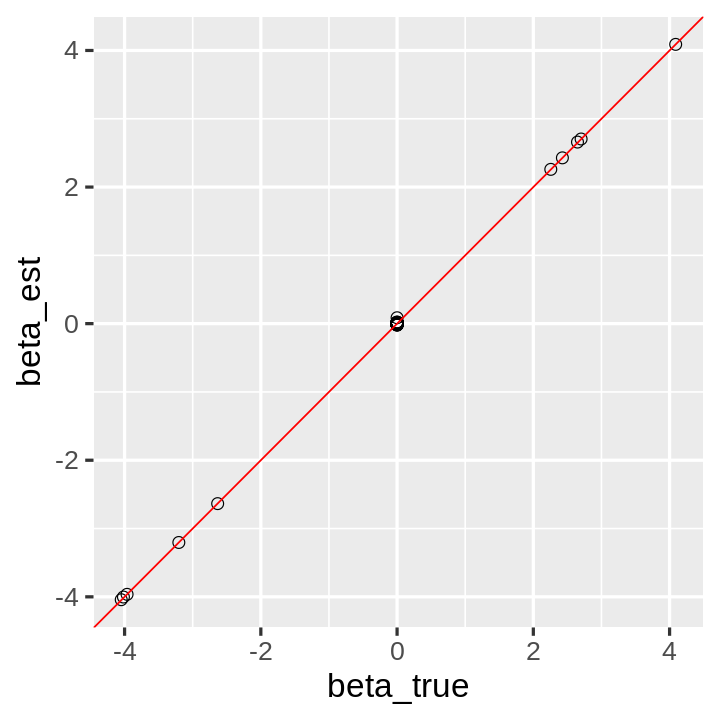

In [23]:
## visualize true and estimated effect sizes
library(ggplot2)
df = data.frame(beta_est=beta_est,beta_true=beta)
options(repr.plot.width=6, repr.plot.height=6) 
theme_set(theme_gray(base_size = 20))
ggplot(df) + aes(x=beta_true, y=beta_est) + geom_point(size=3,shape=1) + geom_abline(slope=1,intercept=0,color='red')

## 5. Real-world examples of sparse matrices

Let's load some real single cell RNA-seq data stored in sparse representation.

This [test matrix file](https://raw.githubusercontent.com/satijalab/seurat/master/tests/testdata/matrix.mtx) suggests that there are 240 genes and 80 cells, and 4,814 (25%) elements have non-zero values.

The file is stored in COO(Tsparsematrix) format following the [MatrixMarket exchange format](https://math.nist.gov/MatrixMarket/formats.html).

In [24]:
cat(readLines("https://raw.githubusercontent.com/satijalab/seurat/master/tests/testdata/matrix.mtx",n=10),sep="\n")

%%MatrixMarket matrix coordinate integer general
240 80 4814
2 1 1
6 1 1
9 1 3
12 1 1
23 1 1
31 1 4
33 1 3
35 1 1


The information about 240 rows (genes) looks is stored in [this gene table file](https://raw.githubusercontent.com/satijalab/seurat/master/tests/testdata/genes.tsv)

In [25]:
cat(readLines("https://raw.githubusercontent.com/satijalab/seurat/master/tests/testdata/genes.tsv",n=10),sep="\n")

ENSGXXXXXX	MS4A1
ENSGXXXXXX	CD79B
ENSGXXXXXX	CD79A
ENSGXXXXXX	HLA-DRA
ENSGXXXXXX	TCL1A
ENSGXXXXXX	HLA-DQB1
ENSGXXXXXX	HVCN1
ENSGXXXXXX	HLA-DMB
ENSGXXXXXX	LTB
ENSGXXXXXX	LINC00926


The sparse matrix stored in [MatrixMarketm exchange format](https://math.nist.gov/MatrixMarket/formats.html) can be loaded with `Matrix::readMM()` function.

In [26]:
## read the sparse matrix
mtx = readMM("https://raw.githubusercontent.com/satijalab/seurat/master/tests/testdata/matrix.mtx")

## read the gene information
genes = read.table("https://raw.githubusercontent.com/satijalab/seurat/master/tests/testdata/genes.tsv")

In [27]:
## print the dimensions
print(dim(mtx))
print(dim(genes))
## peek the contents of the files
print(mtx[1:5,1:5])
print(head(genes))

[1] 240  80
[1] 240   2
5 x 5 sparse Matrix of class "dgTMatrix"
              
[1,] . . . . .
[2,] 1 . . . .
[3,] . . . . .
[4,] . 1 . . 1
[5,] . . . . .
          V1       V2
1 ENSGXXXXXX    MS4A1
2 ENSGXXXXXX    CD79B
3 ENSGXXXXXX    CD79A
4 ENSGXXXXXX  HLA-DRA
5 ENSGXXXXXX    TCL1A
6 ENSGXXXXXX HLA-DQB1


In [28]:
## summary(mtx) returns non-zero elements with its indices
mtx.df = summary(mtx)
print(head(mtx.df))

240 x 80 sparse Matrix of class "dgTMatrix", with 4814 entries 
   i j x
1  2 1 1
2  6 1 1
3  9 1 3
4 12 1 1
5 23 1 1
6 31 1 4


In [29]:
## add a gene name column corresponding to gene index
mtx.df$gene = genes$V2[mtx.df$i]
print(head(mtx.df))

240 x 80 sparse Matrix of class "dgTMatrix", with 4814 entries 
   i j x     gene
1  2 1 1    CD79B
2  6 1 1 HLA-DQB1
3  9 1 3      LTB
4 12 1 1    SP100
5 23 1 1    CXCR4
6 31 1 4     CD3D


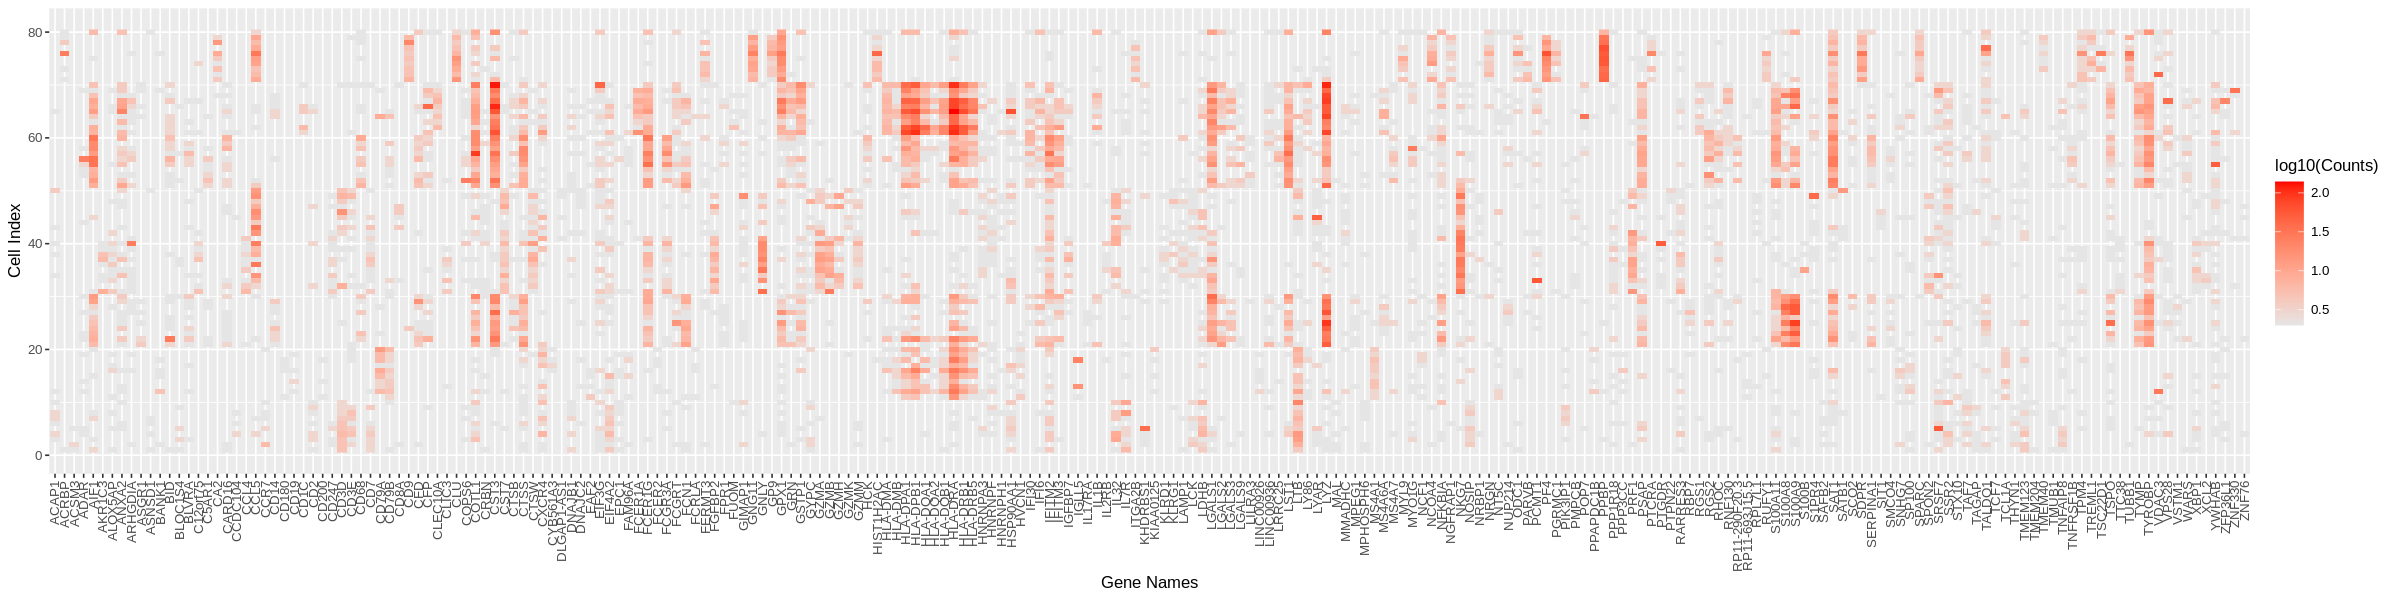

In [30]:
## Visualize non-zero elements using geom_raster()
options(repr.plot.width=20, repr.plot.height=5) 
theme_set(theme_gray(base_size = 10))
ggplot(mtx.df) + aes(x=gene,y=j) + geom_raster(aes(fill=log10(x+1))) +
  scale_fill_gradient(low="grey90", high="red") +
  labs(x="Gene Names",y="Cell Index",fill="log10(Counts)") +
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))